   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0  1.125100  1.178124  0.493516  0.790880 -0.614278  1.347020  1.419515   
1 -0.564641  3.638629 -1.522415 -1.541705  1.616697  4.781310  3.190292   
2  0.516313  2.165426 -0.628486 -0.386923  0.492518  1.442381  1.332905   
3  0.537282  0.966618 -0.115420  0.670755 -0.958516  0.871440  0.508186   
4  0.278385  1.065828 -1.724917 -2.235667  0.715107  0.731249 -0.674119   

   sensor_8  sensor_9  sensor_10  failure_status           timestamp  
0  1.357325  0.966041  -1.981139               1 2023-01-01 00:00:00  
1 -0.890254  1.438826  -3.828748               0 2023-01-01 01:00:00  
2 -1.958175 -0.348803  -1.804124               0 2023-01-01 02:00:00  
3 -1.034471 -1.654176  -1.910503               1 2023-01-01 03:00:00  
4  0.598330 -0.524283   1.047610               0 2023-01-01 04:00:00  
Missing values before handling:
 sensor_1          0
sensor_2          0
sensor_3          0
sensor_4          0
sensor_5  

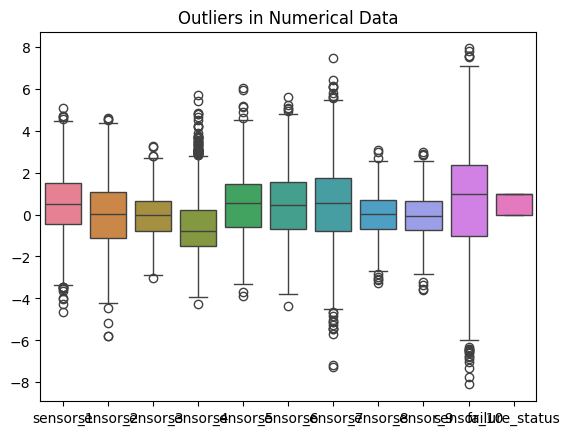

C:\Users\mabdu\AppData\Local\Temp\ipykernel_7792\1988624117.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


Training set shape: (800, 33)
Testing set shape: (200, 33)


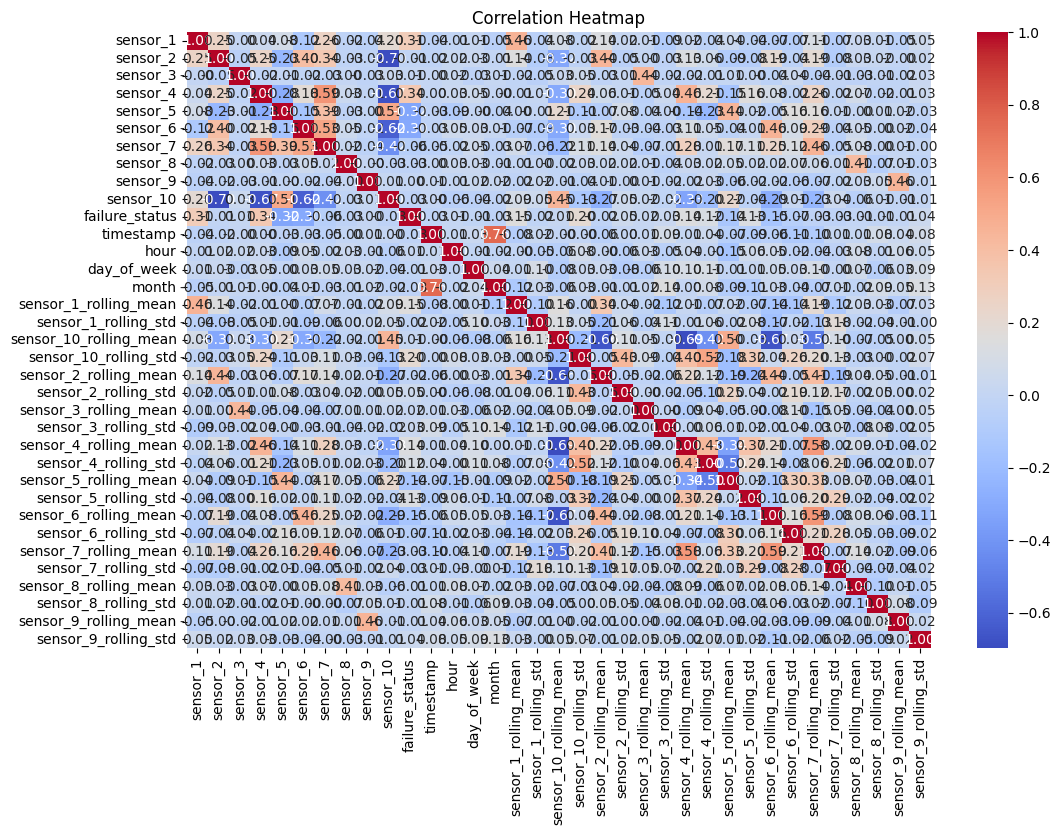

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Step 1: Generate synthetic dataset using make_classification
X, y = make_classification(
    n_samples=1000, n_features=10, 
    n_informative=5, n_redundant=2, 
    random_state=42, n_classes=2
)

# Create a DataFrame
df = pd.DataFrame(X, columns=[f'sensor_{i+1}' for i in range(X.shape[1])])
df['failure_status'] = y

# Add a timestamp column to simulate time-series data
df['timestamp'] = pd.date_range(start='2023-01-01', periods=len(df), freq='H')

# Display the first few rows of the dataset
print(df.head())

# Step 2: Handle Missing Values
# Check for missing values
print("Missing values before handling:\n", df.isnull().sum())

# Simulate missing values in the dataset (for demonstration)
np.random.seed(42)
missing_indices = np.random.choice(df.index, size=50, replace=False)
df.loc[missing_indices, 'sensor_1'] = np.nan

# Fill missing values with the mean of the column
df['sensor_1'].fillna(df['sensor_1'].mean(), inplace=True)
print("Missing values after handling:\n", df.isnull().sum())

# Step 3: Handle Outliers
# Visualize outliers using a boxplot
sns.boxplot(data=df.select_dtypes(include=[np.number]))
plt.title('Outliers in Numerical Data')
plt.show()

# Remove outliers using the Interquartile Range (IQR) method
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'failure_status':  # Skip target variable
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)

# Step 4: Normalize Features
scaler = MinMaxScaler()
numerical_columns = df.select_dtypes(include=[np.number]).columns.difference(['failure_status'])
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Step 5: Create Time-Based Features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Step 6: Add Rolling Statistics
rolling_window = 5  # Rolling window size
for col in numerical_columns:
    df[f'{col}_rolling_mean'] = df[col].rolling(window=rolling_window).mean()
    df[f'{col}_rolling_std'] = df[col].rolling(window=rolling_window).std()

# Fill NaN values caused by rolling operations
df.fillna(method='bfill', inplace=True)

# Step 7: Train-Test Split
# Define features (X) and target (y)
X = df.drop(['failure_status', 'timestamp'], axis=1)
y = df['failure_status']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display shapes of training and testing sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Step 8: Visualize Correlations (Optional)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()